In [68]:
import sys
import os
sys.path.append(os.pardir)
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"
import seaborn as sns
sns.set('paper')

FIGS_PATH = '../figs'
DATA_PATH = 'soil.csv'

In [35]:
def figsize(scale, nplots=1):
    fig_width_pt = 390.0                               
    inches_per_pt = 1.0/72.27
    golden_mean = (np.sqrt(5.0)-1.0)/2.0
    fig_width = fig_width_pt*inches_per_pt*scale 
    fig_height = fig_width*golden_mean*nplots
    fig_size = [fig_width,fig_height]
    return fig_size

def grad(y, dx=1, order=1):
    if order not in [1, 2]:
        raise ValueError(
            'Only 1st and 2nd order finite differences are supported.'
        )
    if order == 1:
        y_xc = (np.diff(y)[:-1] + np.diff(y)[1:]) / (2*dx)
        y_x_1st_el = (y[1] - y[0]) / dx
        y_x_last_el = (y[-1] - y[-2]) / dx
        return np.r_[
            y_x_1st_el,
            y_xc,
            y_x_last_el,
        ]
    else:
        y_xc = (y[:-2] - 2*y[1:-1] + y[2:]) / (dx**2)
        y_x_1st_el = (y[2] - 2*y[1] + y[0]) / (dx**2)
        y_x_last_el = (y[-1]- 2*y[-2] + y[-3]) / (dx**2)
        return np.r_[
            y_x_1st_el,
            y_xc,
            y_x_last_el,
        ]

In [36]:
headers = ['time', 'pressure', 'air_temp', 'air_humidity', 'soil_temp', 'soil_humidity']
data = pd.read_csv(DATA_PATH, header=0, names=headers)
data.head(10)

,time,pressure,air_temp,air_humidity,soil_temp,soil_humidity
0,2020-01-08 19:00:00,1028.483333,21.914673,27.285767,2.501343,33.355824
1,2020-01-08 20:00:00,1028.583333,21.221924,28.256226,2.400635,33.373580
2,2020-01-08 21:00:00,1028.600000,20.533752,28.845215,2.299927,33.391335
3,2020-01-08 22:00:00,1028.916667,20.198059,28.924561,2.249573,33.409091
4,2020-01-08 23:00:00,1029.116667,19.819641,28.936768,2.199219,33.409091
5,2020-01-09 00:00:00,1028.683333,19.703674,28.897095,2.060364,33.400213
6,2020-01-09 01:00:00,1029.183333,19.401550,28.677368,2.000854,33.391335
7,2020-01-09 02:00:00,1029.083333,19.154358,28.485107,1.920288,33.373580
8,2020-01-09 03:00:00,1028.333333,18.986511,28.433228,1.900146,33.364702
9,2020-02-12 12:00:00,1015.000000,23.837280,46.075439,7.300000,22.418182


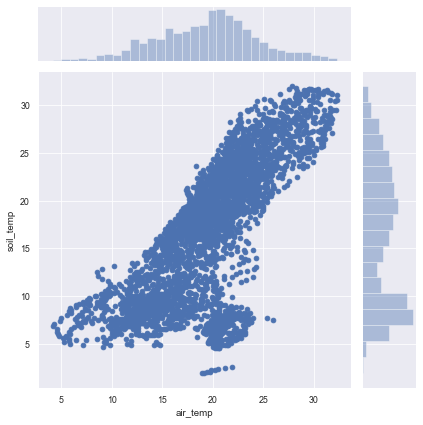

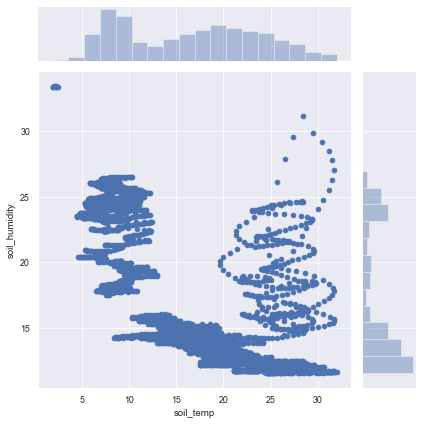

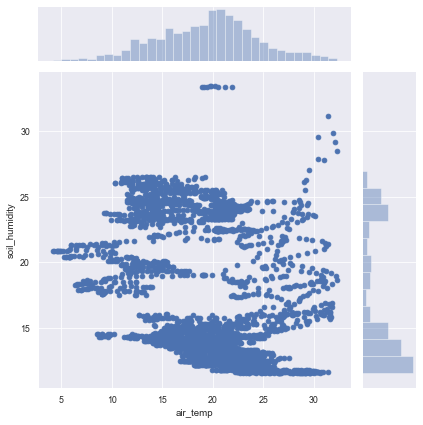

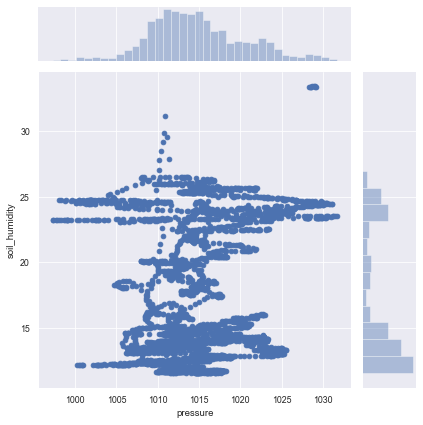

In [78]:
sns.jointplot(x='air_temp', y='soil_temp', data=data)
sns.jointplot(x='soil_temp', y='soil_humidity', data=data)
sns.jointplot(x='air_temp', y='soil_humidity', data=data)
sns.jointplot(x='pressure', y='soil_humidity', data=data)
plt.show()

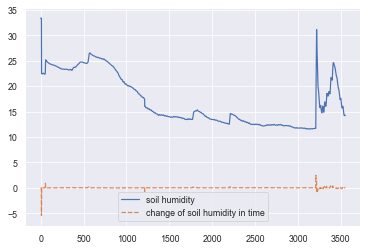

In [89]:
t0 = datetime.datetime.strptime(data.time[0], '%Y-%m-%d %H:%M:%S')
t1 = datetime.datetime.strptime(data.time[1], '%Y-%m-%d %H:%M:%S')
dt = (t1 - t0).seconds / 3600

soil_humidity_dt = grad(data.soil_humidity.values, dt, order=1)

plt.plot(data.soil_humidity.values, '-', label='soil humidity')
plt.plot(soil_humidity_dt, '--', label='change of soil humidity in time')
plt.legend()
plt.show()